# Ice Caps and Ice Belts: The Effects of Obliquity on Ice-Albedo Feedback

## Brian E. J. Rose, Timothy W. Cronin and Cecilia M. Bitz

### Revised for Astrophys. J., July 2017

This notebook reproduces most of the figures in the manuscript using open-source Python packages.

The [climlab package](https://github.com/brian-rose/climlab) is a general-purpose, Python-based climate modeling engine created by Brian Rose. It is used here for the insolation calculations, as well as for implementation of the numerical seasonal Energy Balance Model. It is open-source and freely available under the MIT license. It is available on the `conda-forge` channel (see link above for installation instructions).

Code specific to the analytical model introduced in this paper is included in the file `ebm_analytical.py`

### Full list of dependencies

- `python 2.7`
- `numpy`
- `scipy`
- `mpmath`  (for complex special functions in the analytical model)
- `ipyparallel` (for parallelization of the seasonal model parameter sweep on a compute cluster)
- `climlab`  (for insolation and implementation of the seasonal EBM)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import brentq
import pickle, itertools
from climlab import constants as const
from climlab.solar.insolation import daily_insolation
import ebm_analytical as ebm
import seasonal_ebm as seas

In [2]:
# Make plots look like they used to before the matplotlib 2.0 upgrade...
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = 'w' 

### Figure 1

This sketch was created in a graphical editor but is included as an image file here:

![Figure 1](obliquity_insolation_sketch.png)

### Figure 2: Insolation

We use a Fourier-Legendre expansion

\begin{equation}  
s(x, t) = 1 + s_{11} \cos(\tau) P_1(x) + \left(  s_{20} + s_{22} \cos(2 \tau) \right) P_2(x)
\end{equation}

where 
\begin{align}
P_1(x) &= x  \\
P_2(x) &= \frac{1}{2}\big( 3 x^2-1\big)
\end{align}
are the 1st and 2nd Legendre polynomials, and $x = \sin\phi$ with $\phi$ the latitude.

$\tau$ is a non-dimensional time angle with $\tau=0, \pi$ at the NH winter, summer solstices.

### Effects of obliquity on insolation

For a circular orbit, we have these simple relationships between insolation components and obliquity angle $\beta$:

\begin{align}
s_{20} &= \frac{5}{16} (3 \sin^2{\beta} - 2)   \\
s_{11} &= -2 \sin{\beta} \\
s_{22} &= \frac{15}{16} \sin^2{\beta} 
\end{align}

In [3]:
def compute_insolation(orb=const.orb_present):
    #  Evenly spaced mesh in sin(latitude) so mean is area-weighted
    x = np.arange(-0.995, 1.001, 0.01)
    lat = np.rad2deg(np.arcsin(x))
    #  vernal equinox is always on day 80
    #  we want days = 0 at NH winter solstice
    day_offset = const.days_per_year/4. - 80.
    days = np.linspace(-day_offset, const.days_per_year-day_offset, 500. )
    Q = daily_insolation(lat, days, orb=orb, S0=4.)
    tau = (days+day_offset) / const.days_per_year * 2*np.pi
    Qann = np.mean(Q, axis=1)
    return tau, x, Q, Qann

def contour_insolation(ax, tau, x, Q, orb=const.orb_present, draw_approx=False, draw_error=False):
    '''Contour plot of normalized insolation for given orbital parameters'''
    levs = np.arange(0,4.25,0.25)
    cax = ax.contourf(tau, x, Q, levels=levs, cmap=plt.cm.afmhot, vmin=-0.5, vmax=4.0)
    ax.set_ylabel(r'$x = \sin\phi$', fontsize=20)
    ax.set_title('Obliquity = {:.1f}'.format(orb['obliquity']), fontsize=16 )
    ax.contourf( tau, x, Q, levels=[-1000., 0.], colors='k')
    tau_ticks = np.pi * np.array([0., 0.5, 1., 1.5, 2.])
    tau_tick_labels = [r'$0$', r'$\pi / 2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
    ax.set_xticks(tau_ticks)
    ax.set_xticklabels(tau_tick_labels, fontsize=16)
    
    #  Compute approximate insolation for this obliquity
    beta = np.deg2rad(orb['obliquity'])
    taugrid, xgrid = np.meshgrid(tau, x)
    s = ebm.s_seasonal(taugrid, xgrid, beta)

    if draw_approx:
        ax.contour(tau, x, s, levels=levs, 
                   colors='k', linestyles='dashed', linewidths=0.5)
    if draw_error:
        CS = ax.contour(tau, x, s-Q, colors='c', levels=np.arange(-1.05,1.05,0.1), linewidths=0.5, alpha=0.75)
        #plt.clabel(CS, fontsize=9, inline=1, fmt='%1.2f')
    return cax

In [4]:
orb_present = const.orb_present
orb_zero = {'ecc':0., 'long_peri':0., 'obliquity':0.}
orb_55 = {'ecc':0., 'long_peri':0., 'obliquity':55.}
orb_90 = {'ecc':0., 'long_peri':0., 'obliquity':90.}

orblist = [orb_zero, orb_present, orb_55, orb_90]

/Users/br546577/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


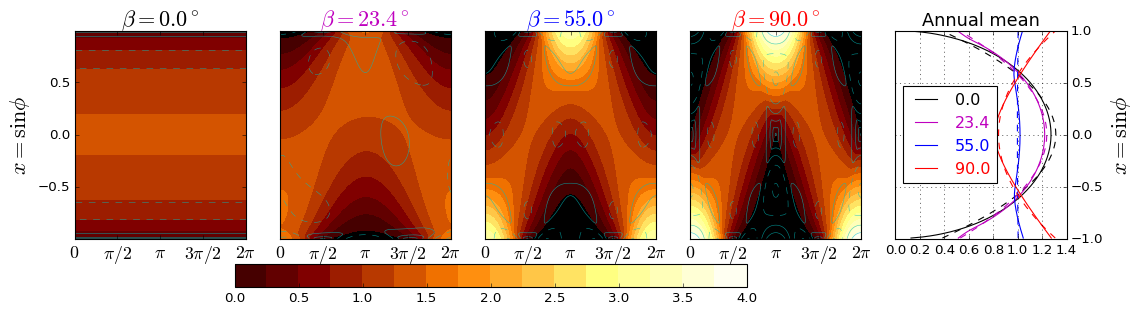

In [5]:
###  Arrange the plots horizontally in a single line
fig = plt.figure(figsize=(16,4))
ncols = len(orblist) + 1
gs = gridspec.GridSpec(1,ncols)
Qannlist = []

#  axis for annual mean plots
ann_ax = fig.add_subplot(gs[0,-1])
colors = ['k', 'm', 'b', 'r']

for n, orb in enumerate(orblist):
    tau, x, Q, Qann = compute_insolation(orb=orb)
    #  axis for individual contour plots
    ax = fig.add_subplot(gs[0,n])
    cax = contour_insolation(ax, tau, x, Q, orb=orb, draw_error=True)
    if n != 0:
        ax.yaxis.set_visible(False)
    ax.set_title(r'$\beta = {:.1f}^\circ$'.format(orb['obliquity']), fontsize=20, color=colors[n])
    #  annual mean plot
    obl = orb['obliquity']
    beta = np.deg2rad(obl)
    ann_ax.plot(Qann, x, label='{:.1f}'.format(obl), color=colors[n])
    ann_ax.plot(ebm.sbar(beta,x), x, '--', color=colors[n])
# Color-code the annual-mean figure legend
l = ann_ax.legend(loc='best')
for n, text in enumerate(l.get_texts()):
    text.set_color(colors[n])
ann_ax.grid();
ann_ax.yaxis.tick_right()
ann_ax.yaxis.set_label_position('right')
ann_ax.set_ylabel(r'$x = \sin\phi$', fontsize=20)
ann_ax.set_title('Annual mean', fontsize=16)

#  Put a single colorbar at the bottom of figure
fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.25, 0.1, 0.4, 0.07]);
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal');

#fig.savefig('insolation_obliquity.pdf')

### Figure 3

In [6]:
num_obl = 100
obl = np.linspace(0., 90., num_obl)
beta = np.deg2rad(obl)
error = np.zeros_like(obl)
annerror = np.zeros_like(obl)

for m in range(num_obl):
    orb = {'ecc':0., 'long_peri':0., 'obliquity':obl[m]}
    tau, x, Q, Qann = compute_insolation(orb)
    Qseries = np.zeros_like(Q)
    for n in range(tau.size):
        Qseries[:,n] = ebm.s_seasonal(tau[n], x, beta[m])
    Qseries_ann = Qseries.mean(axis=1)
    error[m] = np.sqrt(np.mean((Q-Qseries)**2))
    annerror[m] = np.sqrt(np.mean((Qann-Qseries_ann)**2))

/Users/br546577/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


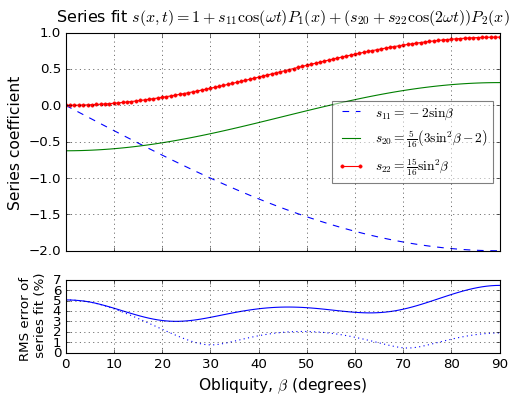

In [7]:
fig, axes = plt.subplots(2, figsize=(7,5),
                         sharex=True, 
                         gridspec_kw = {'height_ratios':[3, 1]}
                        )
ax = axes[0]
ax.plot(obl, ebm.s11(beta), '--', label=r'$s_{11} = -2 \sin\beta$')
ax.plot(obl, ebm.s20(beta), '-', label=r'$s_{20} = \frac{5}{16} \left( 3\sin^2\beta - 2 \right)$')
ax.plot(obl, ebm.s22(beta), '.-', label=r'$s_{22} = \frac{15}{16} \sin^2\beta $')
leg = ax.legend(loc = 'center right', fontsize=12)
# set the alpha value of the legend: it will be translucent
leg.get_frame().set_alpha(0.5)
ax.set_ylabel('Series coefficient', fontsize=14)
ax.set_title(r'Series fit $s(x, t) = 1+s_{11}\cos(\omega t)P_1(x)+\left(s_{20}+s_{22}\cos(2\omega t)\right)P_2(x)$',
            verticalalignment='bottom')

ax = axes[1]
ax.set_ylabel('RMS error of \n series fit (%)', fontsize=12)
ax.set_xlabel(r'Obliquity, $\beta$ (degrees)', fontsize=14)
ax.plot(obl, 100*error, 'b-')
ax.plot(obl, 100*annerror, 'b:')
for ax in axes:
    ax.grid()

#fig.savefig('obliquity_lfseries_fit_new.pdf')

### Figure 4

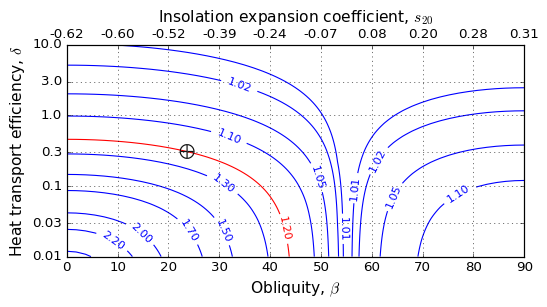

In [8]:
#  delta ranging from 0.01 to 10, evenly in log space
log10delta = np.linspace(-2., 1., 100)
obliquity = np.linspace(0., 90.)
beta, delta = np.meshgrid(np.deg2rad(obliquity), 10**log10delta)

fig, ax = plt.subplots(figsize=(7,4))
#  contour qwarm. Draw the 1.2 contour in a special color for emphasis
CS = ax.contour(obliquity, log10delta, ebm.qwarm(delta, ebm.s2(beta)),
            levels=[1, 1.01, 1.02, 1.05, 1.1, 1.2, 1.3, 1.5, 1.7, 2, 2.2, 2.4],
            colors=['b', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b'])
plt.clabel(CS, inline=1, fontsize=10, fmt='%1.2f')
ax.set_xlabel(r'Obliquity, $\beta$', fontsize=14)
ax.set_ylabel(r'Heat transport efficiency, $\delta$', fontsize=14)
yticks = np.arange(-2., 1.1, 0.5)
deltaticks = np.array([0.01, 0.03, 0.1, 0.3, 1.0, 3., 10.])
ax.set_yticks(np.log10(deltaticks))
ax.set_yticklabels(deltaticks)
ax.grid()
oblticks = np.arange(0., 100., 10.)
ax.set_xticks(oblticks)
ax2 = ax.twiny()
ax2.set_xticks(oblticks)
s2ticks = ['%1.2f'%F for F in ebm.s2(np.deg2rad(oblticks))]
ax2.set_xticklabels(s2ticks)
ax2.set_xlabel(r'Insolation expansion coefficient, $s_{20}$', fontsize=14)
ax.plot(23.45, np.log10(0.31), color='w', marker='$\oplus$', markersize=14)

fig.tight_layout()
#fig.savefig('qwarm_contours.pdf')

### Figure 5

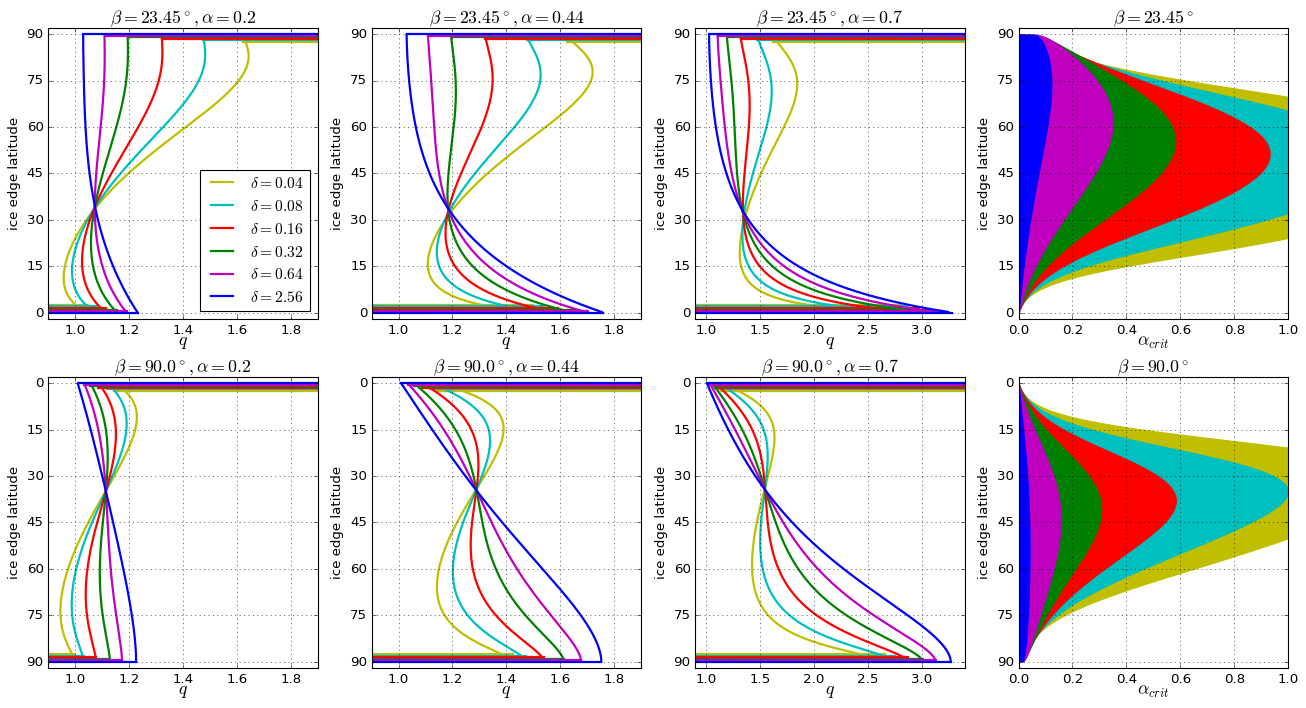

In [9]:
lat = np.arange(0.2, 90., 0.2)
phi = np.deg2rad(lat)
xsarray = np.sin(phi)

obl = np.array([23.45, 90.])
alpha = [0.2, 0.44, 0.7]

delta = [0.04, 0.08, 0.16, 0.32, 0.64, 2.56]
colors = ['y', 'c', 'r', 'g', 'm', 'b']
offset = [2.5, 2.0, 1.5, 1, 0.5, 0]

fig, axes = plt.subplots(len(obl), len(alpha)+1, figsize=(20,10))
for n, beta in enumerate(np.deg2rad(obl)):
    for m, a in enumerate(alpha):
        ax = axes[n,m]
        for nd, d in enumerate(delta):
            ax.plot(ebm.q(xsarray, d, ebm.s2(beta), a), lat, color=colors[nd], label=r'$\delta = {}$'.format(d), linewidth=2)
            if ebm.s2(beta)<0:
                # ice-free branch
                ax.plot([ebm.qwarm(d,ebm.s2(beta)), 4], np.array([90,90]) - offset[nd], color=colors[nd], linewidth=2)
                #  snowball branch
                ax.plot([0, ebm.qsnow(d,ebm.s2(beta),a)], np.array([0, 0]) + offset[nd], color=colors[nd], linewidth=2)
            else:
                #  snowball branch
                ax.plot([0, ebm.qsnow(d,ebm.s2(beta),a)], np.array([90,90]) - offset[nd], color=colors[nd], linewidth=2)
                #  ice-free branch
                ax.plot([ebm.qwarm(d,ebm.s2(beta)), 4], np.array([0, 0]) + offset[nd], color=colors[nd], linewidth=2)                
        ax.grid()
        ax.set_title(r'$\beta = {1}^\circ, \alpha = {0}$'.format(a,obl[n]), fontsize=16)
        ax.set_xlabel(r'$q$', fontsize=16, labelpad=-3)
        ax.set_ylabel('ice edge latitude', fontsize=12)
        ax.set_ylim(-2, 92)
        ax.set_yticks(np.arange(0,100,15))
        if m==2:
            ax.set_xlim(0.9, 3.4)
        else:
            ax.set_xlim(0.9, 1.9)
        #  try flipping the high-obliquity plots upside down
        if ebm.s2(beta)>0:
            ax.invert_yaxis()
axes[0,0].legend(loc='best', fontsize=14)

#  Plots of stable alpha regions
for n, beta in enumerate(np.deg2rad(obl)):
    ax = axes[n,-1]
    for nd, d in enumerate(delta):
        ax.fill_betweenx(lat, 0, ebm.alpha_crit(xsarray, d, ebm.s2(beta)), color=colors[nd])
    ax.grid()
    ax.set_title(r'$\beta = {0}^\circ$'.format(obl[n]), fontsize=16)
    ax.set_ylabel('ice edge latitude', fontsize=12)
    ax.set_xlim(0,1)
    ax.set_xlabel(r'$\alpha_{crit}$', fontsize=16, labelpad=-3)
    ax.set_ylim(-2, 92)
    ax.set_yticks(np.arange(0,100,15))

#  try flipping the high-obliquity plots upside down
axes[1,-1].invert_yaxis()
#axes[1,-1].set_xlabel(r'$\alpha_{crit}$', fontsize=16)

#fig.savefig('iceedge_plots_alphacrit.pdf')

The published version includes some annotations that were added manually with a graphics editor:

![Figure 5](iceedge_plots_alphacrit_annotated.pdf)

### Figure 6

In [10]:
alpha_array = np.linspace(0., 1., 50)

d = 0.16
obl_low = 23.45; obl_high = 90.
s2_low = ebm.s2(np.deg2rad(obl_low))
xs_big, alpha_big = np.meshgrid(xsarray, alpha_array)
qbig_low = ebm.q(xs_big, d, s2_low, alpha_big)

s2_high = ebm.s2(np.deg2rad(obl_high))
qbig_high = ebm.q(xs_big, d, s2_high, alpha_big)

In [11]:
qbig_low_minus_qsnow = qbig_low - ebm.qsnow(d, s2_low, alpha_big)
qbig_high_minus_qsnow = qbig_high - ebm.qsnow(d, s2_high, alpha_big)

ebm_analytical.py:98: RuntimeWarning: divide by zero encountered in divide
  return np.where(s2<0, 1./(1-alpha)/(1-s2/(1+6*delta)/2),
ebm_analytical.py:99: RuntimeWarning: divide by zero encountered in divide
  1./(1-alpha)/(1+s2/(1+6*delta)))


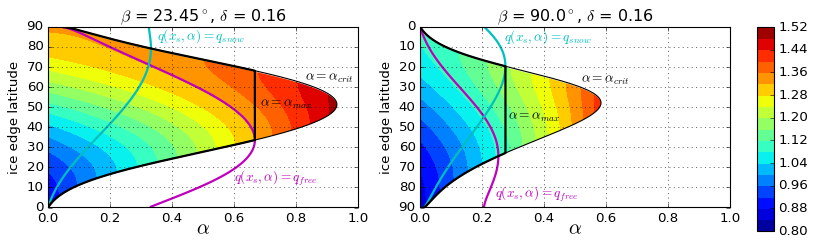

In [12]:
fig, axes = plt.subplots(1,2, figsize=(11,3))
for n, (thisobl, s2, qbig, qbig_minus_qsnow) in enumerate(zip([obl_low, obl_high],
                                                     [s2_low, s2_high],
                                                     [qbig_low,qbig_high],
                                            [qbig_low_minus_qsnow, qbig_high_minus_qsnow])):
    ax = axes[n]
    cax = ax.contourf(alpha_array, lat, qbig.transpose(), 
                      levels=np.arange(0.8, 1.55, 0.04))
    ax.contour(alpha_array, lat, qbig.transpose(), levels=[ebm.qwarm(d,s2)], 
            colors='m', linewidths=2)
    ax.plot(ebm.alpha_crit(xsarray, d, s2), lat, 'k-')
    ax.contour(alpha_array, lat, qbig_minus_qsnow.transpose(), 
               levels=[0], colors='c', linewidths=2)
    ax.grid()
    ax.set_title(r'$\beta$ = {0}$^\circ$, $\delta$ = {1}'.format(thisobl, d))
    ax.fill_betweenx(lat, ebm.alpha_crit(xsarray, d, s2), 1., color='w')
    ax.plot(ebm.alpha_max(xsarray,d,s2), lat, 'k-', linewidth=2)
    ax.set_ylabel('ice edge latitude', fontsize=12)
    ax.set_xlabel(r'$\alpha$', fontsize=18, labelpad=-5)
#  flip the high-obliquity plot upside down
axes[-1].invert_yaxis()
#  Some helpful labels
axes[0].text(0.6, 13, r'$q(x_s,\alpha) = q_{free}$', color='m')
axes[0].text(0.35, 83.5, r'$q(x_s,\alpha) = q_{snow}$', color='c')
axes[0].text(0.83, 63, r'$\alpha = \alpha_{crit}$', color='k')
axes[0].text(0.682, 50, r'$\alpha = \alpha_{max}$', color='k')
axes[1].text(0.24, 85, r'$q(x_s,\alpha) = q_{free}$', color='m')
axes[1].text(0.27, 7, r'$q(x_s,\alpha) = q_{snow}$', color='c')
axes[1].text(0.52, 28, r'$\alpha = \alpha_{crit}$', color='k')
axes[1].text(0.285, 46, r'$\alpha = \alpha_{max}$', color='k')
#  A single colorbar on the right
cbar_ax = fig.add_axes([0.93, 0.05, 0.02, 0.85])
fig.colorbar(cax, cax=cbar_ax);
fig.subplots_adjust(bottom=0.15)
#fig.savefig('alpha_max.pdf')

### Figure 7

This uses pre-computed probabilities loaded from files. See `compute_ice_probability_v3.py` for the code that generates the probabilities.

In [13]:
## new result from cluster using the above condition to exclude inaccessible states
Lice_result_all = np.load('Lice_result_all.npz')
Lice_result_accessible = np.load('Lice_result_accessible.npz')

In [14]:
#  Plot probability normalized to Earth value
ind = 16
Lice_result_all['obliquity'][ind]

23.225806451612904

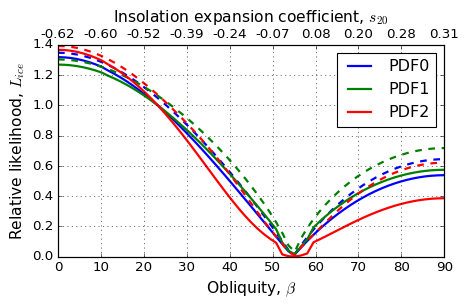

In [15]:
## Plot both together, but normalize by the accessible probability
oblticks = np.arange(0., 100., 10.)
s2ticks = ['%1.2f'%F for F in ebm.s2(np.deg2rad(oblticks))]
colors = ['b', 'g', 'r']
obl = Lice_result_all['obliquity']

fig, ax = plt.subplots(figsize=(6,4))
for n, (Lice_all, Lice_accessible) in enumerate(zip(Lice_result_all['Lice_all'],
                                                    Lice_result_accessible['Lice_accessible'])):
    ax.plot(obl, Lice_all / Lice_accessible[ind], 
            linewidth=2, color=colors[n], linestyle='--')    
    ax.plot(obl, Lice_accessible / Lice_accessible[ind], 
            linewidth=2, label='PDF{}'.format(n), color=colors[n])
#ax.plot(obl, np.abs(ebm.s2(np.deg2rad(obl)) / ebm.s2((np.deg2rad(23.45)))), 
#        'k--', label=r'$|s_2|$')

ax.grid()
ax.legend()

ax.set_xlabel(r'Obliquity, $\beta$', fontsize=14)
ax.set_ylabel(r'Relative likelihood, $L_{ice}$', fontsize=14)
ax.set_xticks(oblticks)
ax2 = ax.twiny()
ax2.set_xticks(oblticks)
ax2.set_xticklabels(s2ticks)
ax2.set_xlabel(r'Insolation expansion coefficient, $s_{20}$', fontsize=14)

fig.tight_layout()

#fig.savefig('Lice_comprehensive.pdf')

### Integrals of likelihood over obliquity space

One final line of argument is to quantify the overall likelihood of observing ice caps versus ice belts. This requires an assumption of the PDF of obliquity. If we take this to be uniform on [0º,90º] then we can just take a simple integral under the graphs above and compare the area under the curves at high and low obliquity.

In [16]:
#  Index closest to the critical obliquity value near 55º
ind_oblcrit = 38
obl[ind_oblcrit]

55.161290322580648

In [17]:
#  Integrate each Lice curve on either side of the critical obliquity
#  Display the fraction of the total Likelihood occurring in the high-obliquity ice belt regime
for n, (Lice_all, Lice_accessible) in enumerate(zip(Lice_result_all['Lice_all'],
                                                    Lice_result_accessible['Lice_accessible'])):
    integral_highobl = np.trapz(Lice_accessible[ind_oblcrit:], obl[ind_oblcrit:])
    integral_lowobl = np.trapz(Lice_accessible[:ind_oblcrit], obl[:ind_oblcrit])
    integral_total = np.trapz(Lice_accessible, obl)
    #print integral_highobl, integral_lowobl
    print integral_highobl / integral_total

0.223638060911
0.240375975914
0.16619871864


The tentative conclusion is that in a universe of uniformly distributed obliquity, only about 20% of observable stable ice edges will be ice belts. The rest will be ice caps.

Note that this is not the same as trying to quantify probabilities relative to observing Snowballs and ice-free planets.

### An alternate assumption for obliquity distribution

Based on planetary accretion simulations by Miguel and Brunini (2010), we might instead choose 

$$ P(\beta) = \sin\beta $$

giving extra weight to high-obliquity states.

In [18]:
#  Integrate each Lice curve on either side of the critical obliquity, weighted by sin(beta)
#  Display the fraction of the total Likelihood occurring in the high-obliquity ice belt regime
for n, (Lice_all, Lice_accessible) in enumerate(zip(Lice_result_all['Lice_all'],
                                                    Lice_result_accessible['Lice_accessible'])):
    integral_highobl = np.trapz(Lice_accessible[ind_oblcrit:]*np.sin(np.deg2rad(obl[ind_oblcrit:])), obl[ind_oblcrit:])
    integral_lowobl = np.trapz(Lice_accessible[:ind_oblcrit]*np.sin(np.deg2rad(obl[:ind_oblcrit])), obl[:ind_oblcrit])
    integral_total = np.trapz(Lice_accessible*np.sin(np.deg2rad(obl)), obl)
    #print integral_highobl, integral_lowobl
    print integral_highobl / integral_total

0.460455376428
0.475463929207
0.386512228482


### Figure 8: minimum $q$ for stable ice edge

The edges of the stable region are defined by

$$ \alpha = \alpha_{crit}(x_s, \delta, s_2) $$

For a given $\delta, s_2, \alpha$, solve $\alpha - \alpha_{crit} = 0$ for the critical latitudes $x_{crit}$

Then evaluate $q_{crit} = q(x_{crit}, \delta, s_2, \alpha)$

In [19]:
def find_q_min(delta, s2, alpha):
    '''Find the minimum value of q for a stable ice edge, if any.'''
    if s2<0:
        a = 0.00001
        b = 0.8
    else:
        a = np.sin(np.deg2rad(40.))
        b = 0.99999
    try:
        xcrit = brentq(lambda x: (ebm.alpha_crit(x, delta, s2) - alpha), a, b)
        return ebm.q(xcrit, delta, s2, alpha), xcrit
    except:
        return None, None

In [20]:
#  PLOTS OF q_hab, defined as minimum of q_warm and q_crit
#   These plots will closely mirror the contour plot of q_warm

#  delta ranging from 0.01 to 10, evenly in log space
log10delta = np.linspace(-2., 1., 100)
obliquity = np.linspace(0., 90.)
beta, delta = np.meshgrid(np.deg2rad(obliquity), 10**log10delta)
alpha = [0.2, 0.44, 0.7]

qmin = np.zeros([len(alpha), len(log10delta), len(obliquity)])
xcrit = np.zeros_like(qmin)
qhab = np.zeros_like(qmin)
qwarm = ebm.qwarm(delta, ebm.s2(beta))

for na, thisalpha in enumerate(alpha):
    for nd, d in enumerate(10**log10delta):
        for ns, thiss2 in enumerate(ebm.s2(np.deg2rad(obliquity))):
            thisqmin, thisxcrit = find_q_min(d, thiss2, thisalpha)
            qmin[na, nd, ns] = thisqmin
            xcrit[na, nd, ns] = thisxcrit

    qhab[na,:,:] = np.minimum(qmin[na,:,:], qwarm)
    qhab[na,:,:] = np.where(np.isnan(qhab[na,:,:]), qwarm, qhab[na,:,:])

In [21]:
#  The minimum value of delta for which qhab is qwarm
log10deltamin = np.zeros((len(alpha), len(obliquity)))
for na, a in enumerate(alpha):
    for ns, thiss2 in enumerate(ebm.s2(np.deg2rad(obliquity))):
        ind = np.where(qhab[na,:,ns]<qwarm[:,ns])[0]
        try:
            log10deltamin[na,ns] = log10delta[max(ind)]
        except:
            log10deltamin[na,ns] = log10delta[0]

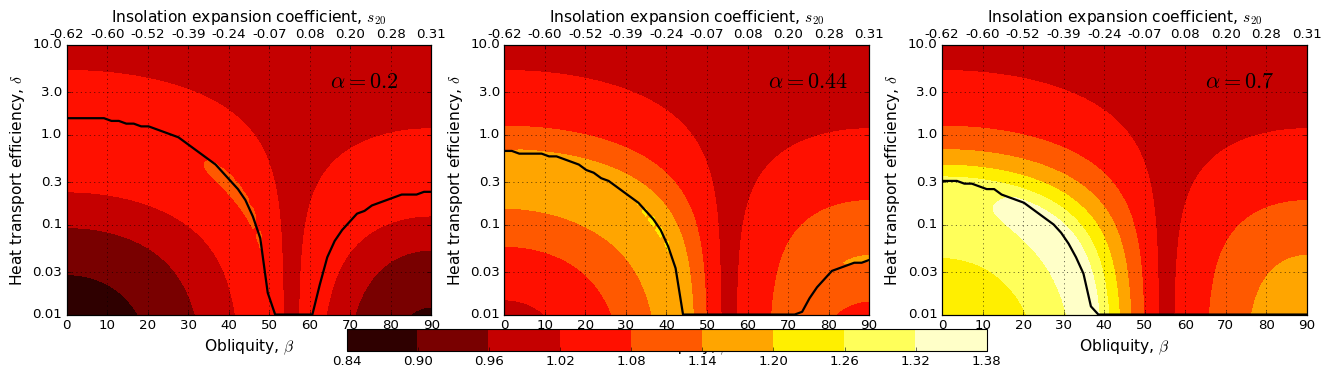

In [22]:
fig, axes = plt.subplots(1,len(alpha), figsize=(20,4.5))

yticks = np.arange(-2., 1.1, 0.5)
deltaticks = np.array([0.01, 0.03, 0.1, 0.3, 1.0, 3., 10.])
oblticks = np.arange(0., 100., 10.)
s2ticks = ['%1.2f'%F for F in ebm.s2(np.deg2rad(oblticks))]
qupper = 1.38
qlower = 0.84

for na, a in enumerate(alpha):
    ax = axes[na]
    CS = ax.contourf(obliquity, log10delta, qhab[na,:,:], levels=np.linspace(qlower, qupper, 10), 
                     vmin=qlower, vmax=qupper, cmap=plt.cm.hot)
    #plt.colorbar(CS)
    #  earth contour value for emphasis
    #ax.contour(obliquity, log10delta, qhab[na,:,:], levels=[0, 1.2], colors='k')
    ax.set_xlabel(r'Obliquity, $\beta$', fontsize=14)
    ax.set_ylabel(r'Heat transport efficiency, $\delta$', fontsize=14)
    ax.set_yticks(np.log10(deltaticks))
    ax.set_yticklabels(deltaticks)
    ax.grid()
    ax.set_xticks(oblticks)
    ax2 = ax.twiny()
    ax2.set_xticks(oblticks)
    ax2.set_xticklabels(s2ticks)
    ax2.set_xlabel(r'Insolation expansion coefficient, $s_{20}$', fontsize=14)
    # place a text box 
    ax.text(65., np.log10(5.), r'$\alpha = {}$'.format(a), fontsize=20,
        verticalalignment='top')
    #  add contour of deltamin
    ax.plot(obliquity, log10deltamin[na,:], color='k', linewidth=2)
#  Put a single colorbar at the bottom of figure
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.06]);
fig.colorbar(CS, cax=cbar_ax, orientation='horizontal');

#fig.savefig('qhab_new.pdf')

### Figures 9 and 10: numerical solutions of the seasonal EBM

These figures result from a large and numerically intensive parameter sweep of the seasonal model. See `seasonal_hysteresis.py` for the code that generated the results in the included data file.

In [23]:
#  Same set of parameters as we used for the annual mean model
obl = [23.45, 90.]
alpha = [0.2, 0.44, 0.7]
delta = [0.04, 0.08, 0.16, 0.32, 0.64, 2.56]
#  And do a shallow and deep water version
gamma = [5., 50.]

In [24]:
pkl_file = open('seasonal_results_600years.p', 'rb')

data1 = pickle.load(pkl_file)
params = data1[0]
results = data1[1]

In [25]:
params == [p for p in itertools.product(obl, alpha, delta, gamma)] 

True

In [26]:
def offset_ice_latitude(ice_area, offset=0, belt=False):
    lat = seas.equivalent_ice_latitude(np.array(ice_area), belt=belt)
    lat = np.where(lat==90., 90.-offset, lat)
    lat = np.where(lat==0., offset, lat)
    return lat

In [27]:
#  Pack the line colors and offsets into a dictionary labeled by delta value
colors = ['y', 'c', 'r', 'g', 'm', 'b']
offset = [2.5, 2.0, 1.5, 1., 0.5, 0]

ddict = {}
for nd, d in enumerate(delta):
    ddict[d] = (colors[nd], offset[nd])

print ddict

{0.16: ('r', 1.5), 2.56: ('b', 0), 0.04: ('y', 2.5), 0.08: ('c', 2.0), 0.32: ('g', 1.0), 0.64: ('m', 0.5)}


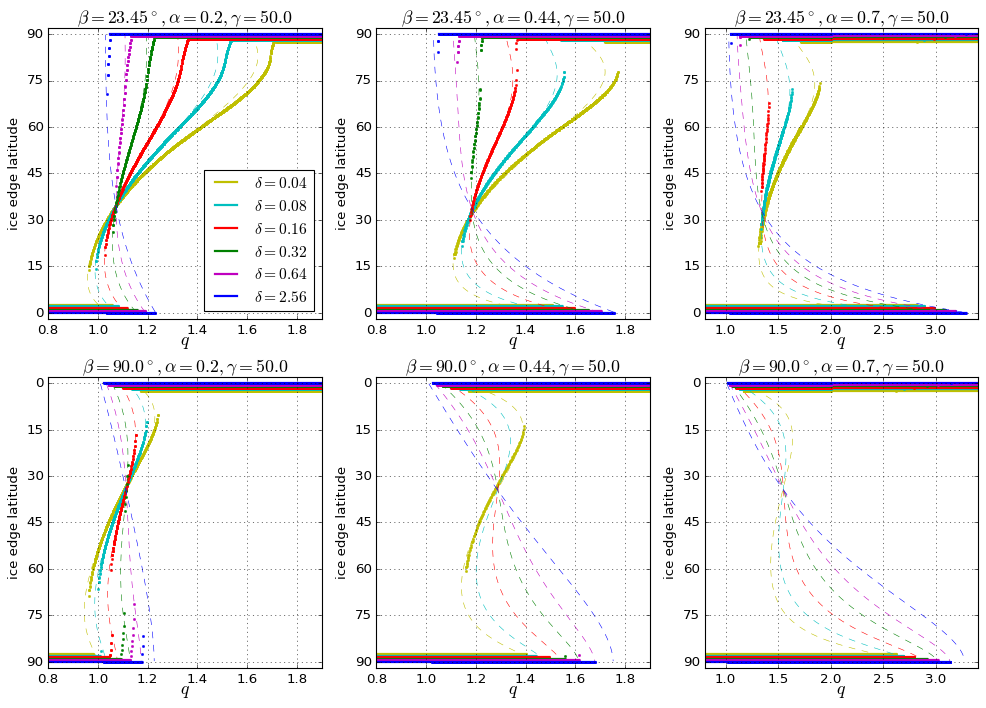

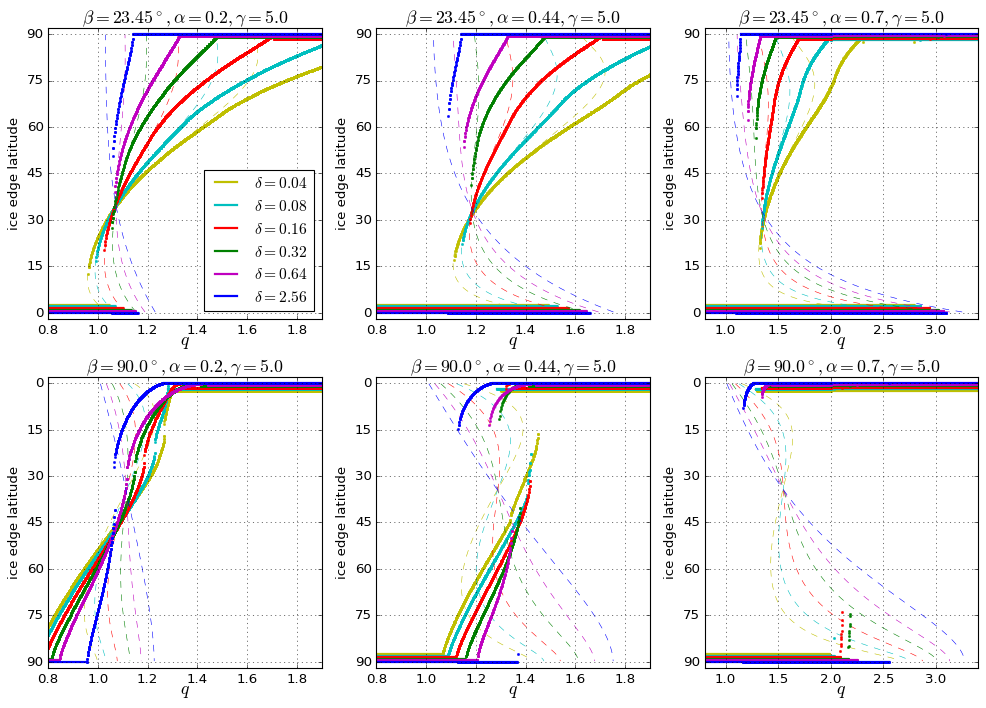

In [28]:
#  Make two sets of plots for deep and shallow water
# Try overlaying the analytical solutions
#  This version DOES NOT use the seasonal correction.

lat = np.arange(0.2, 90., 0.2)
phi = np.deg2rad(lat)
xsarray = np.sin(phi)

pointsize = 4

for this_gamma, name in zip([50., 5.], ['deep', 'shallow']):
    fig, axes = plt.subplots(len(obl), len(alpha), figsize=(20 * 3./4.,10))

    for [b,a,d,g], [ice_area_down, q_down, ice_area_up, q_up, ice_area_stable_up, q_stable_up] in zip(params, results):
        if b == 23.45:
            n = 0
            belt = False
        else:
            n = 1
            belt = True
        if a == 0.2:
            m = 0
        elif a == 0.44:
            m = 1
        else:
            m = 2
        ax = axes[n,m]
        col = ddict[d][0]
        off = ddict[d][1]

        area1 = np.where
        if g==this_gamma:
            ax.plot(q_down, offset_ice_latitude(ice_area_down, offset=off, belt=belt), '.',
                    color=col, markersize=pointsize)
            ax.plot(q_up, offset_ice_latitude(ice_area_up, offset=off, belt=belt),  '.',
                    color=col, markersize=pointsize)
            if ice_area_stable_up is not None:
                ax.plot(q_stable_up, offset_ice_latitude(ice_area_stable_up, offset=off, belt=belt),  '.',
                    color=col, markersize=pointsize)
            if belt:
                freepoints = np.array([0,0])
                snowpoints = np.array([90,90])
                sign = -1
            else:
                freepoints = np.array([90,90])
                snowpoints = np.array([0,0])
                sign = +1
            # ice-free branch
            try:
                qmin = q_down[np.max(np.where(np.array(ice_area_down)==0.))]
                ax.plot([qmin, 4], freepoints - off*sign, color=col, linewidth=2)
            except:
                pass
            #  snowball branch
            try:
                qmax = q_up[np.max(np.where(np.array(ice_area_up)==1.))]
                ax.plot([0, qmax], snowpoints + off*sign, color=col, linewidth=2, label=r'$\delta = {}$'.format(d))
            except:
                pass
            
            # analytical ice edges from annual mean model
            qann = ebm.q(xsarray, d, ebm.s2(np.deg2rad(b)), a)
            ax.plot(qann, lat, '--', color=col, linewidth=0.5)

    for n, beta in enumerate(np.deg2rad(obl)):
        for m, a in enumerate(alpha):
            ax = axes[n,m]     
            ax.grid()
            ax.set_title(r'$\beta = {1}^\circ, \alpha = {0}, \gamma = {2}$'.format(a,obl[n],this_gamma), fontsize=16)
            ax.set_xlabel(r'$q$', fontsize=16, labelpad=-3)
            ax.set_ylabel('ice edge latitude', fontsize=12)
            ax.set_ylim(-2, 92)
            ax.set_yticks(np.arange(0,100,15))
            if m==2:
                ax.set_xlim(0.8, 3.4)
            else:
                ax.set_xlim(0.8, 1.9)
            #  try flipping the high-obliquity plots upside down
            if ebm.s2(beta)>0:
                ax.invert_yaxis()
    axes[0,0].legend(loc='best', fontsize=14)
    
    filename = 'seasonal_iceedge_' + name + '.pdf'
    #fig.savefig(filename)

## BONUS: stability diagrams for 0º obliquity

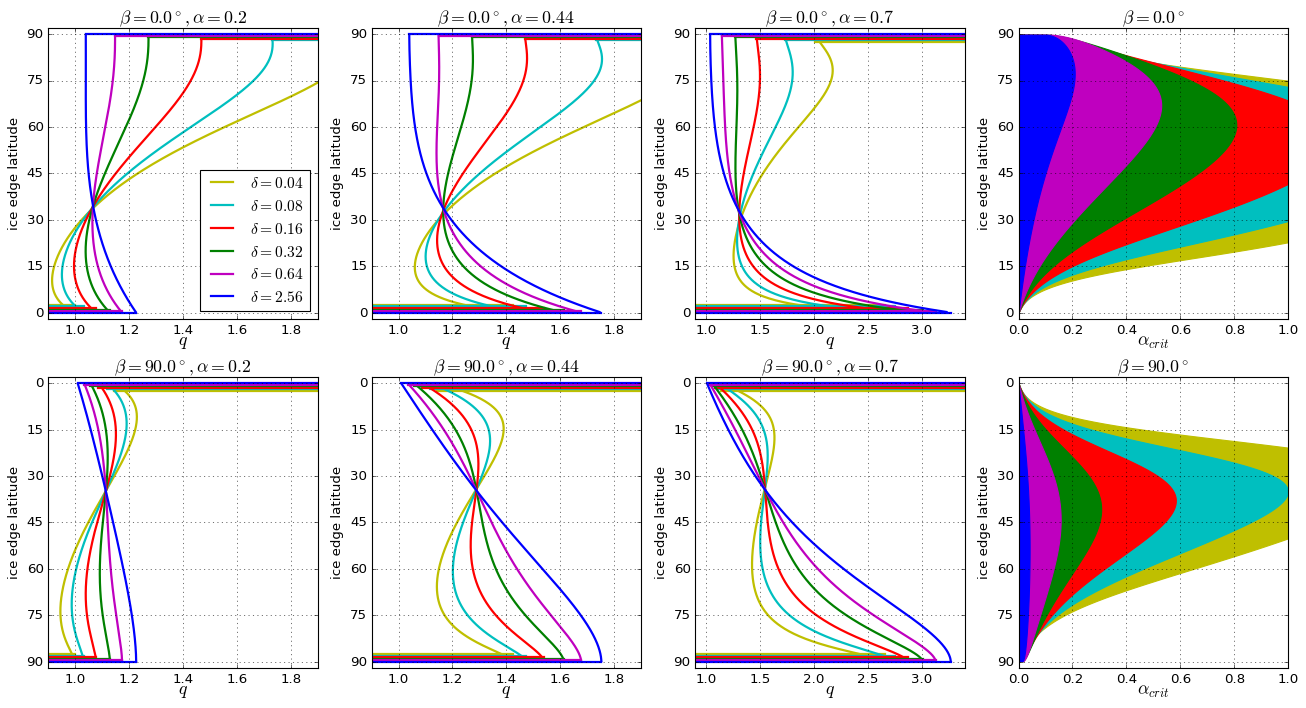

In [29]:
lat = np.arange(0.2, 90., 0.2)
phi = np.deg2rad(lat)
xsarray = np.sin(phi)

obl = np.array([0., 90.])
alpha = [0.2, 0.44, 0.7]

delta = [0.04, 0.08, 0.16, 0.32, 0.64, 2.56]
colors = ['y', 'c', 'r', 'g', 'm', 'b']
offset = [2.5, 2.0, 1.5, 1, 0.5, 0]

fig, axes = plt.subplots(len(obl), len(alpha)+1, figsize=(20,10))
for n, beta in enumerate(np.deg2rad(obl)):
    for m, a in enumerate(alpha):
        ax = axes[n,m]
        for nd, d in enumerate(delta):
            ax.plot(ebm.q(xsarray, d, ebm.s2(beta), a), lat, color=colors[nd], label=r'$\delta = {}$'.format(d), linewidth=2)
            if ebm.s2(beta)<0:
                # ice-free branch
                ax.plot([ebm.qwarm(d,ebm.s2(beta)), 4], np.array([90,90]) - offset[nd], color=colors[nd], linewidth=2)
                #  snowball branch
                ax.plot([0, ebm.qsnow(d,ebm.s2(beta),a)], np.array([0, 0]) + offset[nd], color=colors[nd], linewidth=2)
            else:
                #  snowball branch
                ax.plot([0, ebm.qsnow(d,ebm.s2(beta),a)], np.array([90,90]) - offset[nd], color=colors[nd], linewidth=2)
                #  ice-free branch
                ax.plot([ebm.qwarm(d,ebm.s2(beta)), 4], np.array([0, 0]) + offset[nd], color=colors[nd], linewidth=2)                
        ax.grid()
        ax.set_title(r'$\beta = {1}^\circ, \alpha = {0}$'.format(a,obl[n]), fontsize=16)
        ax.set_xlabel(r'$q$', fontsize=16, labelpad=-3)
        ax.set_ylabel('ice edge latitude', fontsize=12)
        ax.set_ylim(-2, 92)
        ax.set_yticks(np.arange(0,100,15))
        if m==2:
            ax.set_xlim(0.9, 3.4)
        else:
            ax.set_xlim(0.9, 1.9)
        #  try flipping the high-obliquity plots upside down
        if ebm.s2(beta)>0:
            ax.invert_yaxis()
axes[0,0].legend(loc='best', fontsize=14)

#  Plots of stable alpha regions
for n, beta in enumerate(np.deg2rad(obl)):
    ax = axes[n,-1]
    for nd, d in enumerate(delta):
        ax.fill_betweenx(lat, 0, ebm.alpha_crit(xsarray, d, ebm.s2(beta)), color=colors[nd])
    ax.grid()
    ax.set_title(r'$\beta = {0}^\circ$'.format(obl[n]), fontsize=16)
    ax.set_ylabel('ice edge latitude', fontsize=12)
    ax.set_xlim(0,1)
    ax.set_xlabel(r'$\alpha_{crit}$', fontsize=16, labelpad=-3)
    ax.set_ylim(-2, 92)
    ax.set_yticks(np.arange(0,100,15))

#  try flipping the high-obliquity plots upside down
axes[1,-1].invert_yaxis()
#axes[1,-1].set_xlabel(r'$\alpha_{crit}$', fontsize=16)

#fig.savefig('iceedge_plots_alphacrit.pdf')